In [1]:
# Numerical Operations
import math
import numpy as np

# Reading/Writing Data
import pandas as pd
import os
import csv

# For Progress Bar
from tqdm import tqdm

# Pytorch
import torch 
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

# For plotting learning curve
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import classification_report
from torchsummary import summary


/home/sea120424/miniconda3/envs/bob_env1/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class IVFDataset(Dataset):
    '''
    x: Features.
    y: Targets, if none, do prediction.
    '''
    def __init__(self, x, y=None):
        # print(y, len(y))
        
        if y is None:
            self.y = y
        else:
            self.y = torch.LongTensor(y)
        self.x = torch.FloatTensor(x)
        
    def __getitem__(self, idx):
        if self.y is None:
            return self.x[idx]
        else:
            return self.x[idx], self.y[idx]

    def __len__(self):
        return len(self.x)

In [3]:
class DNN_Regression(nn.Module):
    def __init__(self, input_dim):
        super(DNN_Regression, self).__init__()
        # TODO: modify model's structure, be aware of dimensions. 
        self.layers = nn.Sequential(
            nn.Linear(input_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 2)
        )

    def forward(self, x):
        x = self.layers(x)
        x = x.squeeze(1) # (B, 1) -> (B)
        return x

In [4]:
model = DNN_Regression(22)
print(model)

DNN_Regression(
  (layers): Sequential(
    (0): Linear(in_features=22, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=2, bias=True)
  )
)


In [5]:
summary(model, (1, 22))

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

In [ ]:
train_loss=[] 
val_loss=[]

def trainer(train_loader, valid_loader, model, config, device):
    
    # TODO try differnet criterion or optimizer 
    # criterion = nn.MSELoss(reduction='mean')
    # w=torch.tensor([0.1,0.9])
    # criterion = nn.CrossEntropyLoss(weight=w)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config['learning_rate'], betas=(0.9, 0.999), eps=1e-08)
    writer = SummaryWriter()
    
    if not os.path.isdir('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models'):
        os.mkdir('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models') # Create directory of saving models.
    
    n_epochs, best_loss, step, early_stop_count = config['n_epochs'], math.inf, 0, 0
    
    for epoch in range(n_epochs):
        model.train() # Set your model to train mode.
        loss_record = []

        # tqdm is a package to visualize your training progress.
        train_pbar = tqdm(train_loader, position=0, leave=True)
        train_acc = []
        for x, y in train_pbar:
            optimizer.zero_grad()               # Set gradient to zero.
            x, y = x.to(device), y.to(device)   # Move your data to device. 
            pred = model(x)             
            
            loss = criterion(pred, y)
            
            loss.backward()                     # Compute gradient(backpropagation).
            optimizer.step()                    # Update parameters.
            step += 1
            loss_record.append(loss.detach().item())
            
            
            acc = (pred.argmax(dim=-1) == y.to(device)).float().mean()
            train_acc.append(acc)
            
            # Display current epoch number and loss on tqdm progress bar.
            train_pbar.set_description(f'Epoch [{epoch+1}/{n_epochs}]')
            train_pbar.set_postfix({'loss': loss.detach().item()})
        
        print(f"Train Acc: {sum(train_acc) / len(train_acc)}")
        mean_train_loss = sum(loss_record)/len(loss_record)
        train_loss.append(mean_train_loss)
        writer.add_scalar('Loss/train', mean_train_loss, step)

        model.eval() # Set your model to evaluation mode.
        loss_record = []
        val_acc = []
        for x, y in valid_loader:
            x, y = x.to(device), y.to(device)
            with torch.no_grad():
                pred = model(x)
                loss = criterion(pred, y)
                
                acc = (pred.argmax(dim=-1) == y.to(device)).float().mean()
                val_acc.append(acc)

            loss_record.append(loss.item())
            
        mean_valid_loss = sum(loss_record)/len(loss_record)
        val_loss.append(mean_valid_loss)
        print(f"Val Acc: {sum(val_acc) / len(val_acc)}")
        print(f'Epoch [{epoch+1}/{n_epochs}]: Train loss: {mean_train_loss:.4f}, Valid loss: {mean_valid_loss:.4f}')
        writer.add_scalar('Loss/valid', mean_valid_loss, step)

        if mean_valid_loss < best_loss:
            best_loss = mean_valid_loss
            torch.save(model.state_dict(), config['save_path']) # Save your best model
            print('Saving model with loss {:.3f}...'.format(best_loss))
            early_stop_count = 0
        else: 
            early_stop_count += 1

        if early_stop_count >= config['early_stop']:
            print('\nModel is not improving, so we halt the training session.')
            return

In [6]:
device = 'cpu'

config = {
    'seed': 1322,      # Your seed number, you can pick your lucky number. :)
    'select_all': True,   # Whether to use all features.
    'valid_ratio': 0.2,   # validation_size = train_size * valid_ratio
    'n_epochs': 500,     # Number of epochs.            
    'batch_size': 256, 
    'learning_rate': 1e-4,              
    'early_stop': 20,    # If model has not improved for this many consecutive epochs, stop training.     
    'save_path': '/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/DNN_Regression/models/model_classification_SMOTE_Adam.ckpt'  # Your model will be saved here.
}

In [7]:
def same_seed(seed): 
    '''Fixes random number generator seeds for reproducibility.'''
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def train_valid_split(data_set, valid_ratio, seed):
    '''Split provided training data into training set and validation set'''
    valid_set_size = int(valid_ratio * len(data_set)) 
    train_set_size = len(data_set) - valid_set_size
    train_set, valid_set = random_split(data_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(seed))
    return np.array(train_set), np.array(valid_set)

def predict(test_loader, model, device):
    model.eval() # Set your model to evaluation mode.
    preds = []
    for x in tqdm(test_loader):
        x = x.to(device)                        
        with torch.no_grad():                   
            pred = model(x)                     
            preds.append(pred.detach().cpu())   
    preds = torch.cat(preds, dim=0).numpy()  
    return preds

In [8]:
same_seed(config['seed'])

In [9]:
train_x = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/train_binary_x.csv')
train_y = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/train_binary_y.csv')
test_x = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/test_binary_x.csv')
test_y = pd.read_csv('/mnt/hdd18.2t/sea120424/exchange/ML/datasets/project/test_binary_y.csv')

In [10]:
from sklearn.model_selection import train_test_split

train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.10, random_state=42)

In [11]:
print(train_x.shape, train_y.shape)
print(valid_x.shape, valid_y.shape)
print(test_x.shape, test_y.shape)

(112338, 21) (112338, 1)
(12482, 21) (12482, 1)
(31205, 21) (31205, 1)


In [14]:
from imblearn.over_sampling import SMOTE
smt = SMOTE(random_state = 100, sampling_strategy = 1.0)
train_x_smt, train_y_smt = smt.fit_resample(train_x, train_y)
print(train_y_smt.value_counts())

Total number of live births - conceived through IVF
0                                                      98684
1                                                      98684
dtype: int64


In [13]:
#train_x = train_x_smt.to_numpy()
#train_y = train_y_smt.to_numpy().ravel()

train_x = train_x.to_numpy()
train_y = train_y.to_numpy().ravel()
valid_x = valid_x.to_numpy()
valid_y = valid_y.to_numpy().ravel()
test_x  = test_x.to_numpy()
test_y = test_y.to_numpy().ravel()

In [14]:
train_dataset = IVFDataset(train_x, train_y)
valid_dataset = IVFDataset(valid_x, valid_y)
test_dataset = IVFDataset(test_x)

In [15]:
train_loader = DataLoader(train_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
valid_loader = DataLoader(valid_dataset, batch_size=config['batch_size'], shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=False, pin_memory=True)

In [16]:
train_loss = []
val_loss = []
model = DNN_Regression(input_dim=train_x.shape[1]).to(device)

In [22]:
trainer(train_loader, valid_loader, model, config, device)

Epoch [1/500]: 100%|██████████████████████████████████████████████████████| 771/771 [00:03<00:00, 232.89it/s, loss=0.118]


Train Acc: 0.9786232113838196
Val Acc: 0.9613936543464661
Epoch [1/500]: Train loss: 0.0956, Valid loss: 0.1353
Saving model with loss 0.135...


Epoch [2/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 239.25it/s, loss=0.0604]


Train Acc: 0.9786241054534912
Val Acc: 0.9612917304039001
Epoch [2/500]: Train loss: 0.0914, Valid loss: 0.1258
Saving model with loss 0.126...


Epoch [3/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 233.24it/s, loss=0.0971]


Train Acc: 0.978623628616333
Val Acc: 0.9613171815872192
Epoch [3/500]: Train loss: 0.0906, Valid loss: 0.1277


Epoch [4/500]: 100%|██████████████████████████████████████████████████████| 771/771 [00:03<00:00, 243.55it/s, loss=0.082]


Train Acc: 0.9786237478256226
Val Acc: 0.9612917304039001
Epoch [4/500]: Train loss: 0.0905, Valid loss: 0.1261


Epoch [5/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 220.83it/s, loss=0.0655]


Train Acc: 0.9786239266395569
Val Acc: 0.9612407088279724
Epoch [5/500]: Train loss: 0.0904, Valid loss: 0.1276


Epoch [6/500]: 100%|██████████████████████████████████████████████████████| 771/771 [00:03<00:00, 237.46it/s, loss=0.145]


Train Acc: 0.9786230325698853
Val Acc: 0.9613681435585022
Epoch [6/500]: Train loss: 0.0903, Valid loss: 0.1259


Epoch [7/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 240.91it/s, loss=0.0384]


Train Acc: 0.9786191582679749
Val Acc: 0.961266279220581
Epoch [7/500]: Train loss: 0.0903, Valid loss: 0.1278


Epoch [8/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 243.89it/s, loss=0.0287]


Train Acc: 0.9786244034767151
Val Acc: 0.9613171815872192
Epoch [8/500]: Train loss: 0.0902, Valid loss: 0.1296


Epoch [9/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 247.54it/s, loss=0.0432]


Train Acc: 0.9786191582679749
Val Acc: 0.9612407088279724
Epoch [9/500]: Train loss: 0.0902, Valid loss: 0.1290


Epoch [10/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 227.62it/s, loss=0.0598]


Train Acc: 0.9786190390586853
Val Acc: 0.9613681435585022
Epoch [10/500]: Train loss: 0.0901, Valid loss: 0.1280


Epoch [11/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 232.00it/s, loss=0.0966]


Train Acc: 0.978623628616333
Val Acc: 0.9613426327705383
Epoch [11/500]: Train loss: 0.0901, Valid loss: 0.1286


Epoch [12/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 234.66it/s, loss=0.0365]


Train Acc: 0.9786193370819092
Val Acc: 0.9612407088279724
Epoch [12/500]: Train loss: 0.0900, Valid loss: 0.1247
Saving model with loss 0.125...


Epoch [13/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 242.85it/s, loss=0.146]


Train Acc: 0.9786178469657898
Val Acc: 0.9612407088279724
Epoch [13/500]: Train loss: 0.0900, Valid loss: 0.1306


Epoch [14/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 231.42it/s, loss=0.0812]


Train Acc: 0.9786237478256226
Val Acc: 0.9614987969398499
Epoch [14/500]: Train loss: 0.0899, Valid loss: 0.1263


Epoch [15/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 242.31it/s, loss=0.107]


Train Acc: 0.9786185622215271
Val Acc: 0.9613171815872192
Epoch [15/500]: Train loss: 0.0899, Valid loss: 0.1269


Epoch [16/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 226.13it/s, loss=0.0712]


Train Acc: 0.9786137938499451
Val Acc: 0.9612152576446533
Epoch [16/500]: Train loss: 0.0898, Valid loss: 0.1280


Epoch [17/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 222.13it/s, loss=0.0705]


Train Acc: 0.9786139726638794
Val Acc: 0.961266279220581
Epoch [17/500]: Train loss: 0.0898, Valid loss: 0.1248


Epoch [18/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 248.68it/s, loss=0.0711]


Train Acc: 0.978618860244751
Val Acc: 0.9612917304039001
Epoch [18/500]: Train loss: 0.0897, Valid loss: 0.1320


Epoch [19/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:02<00:00, 264.93it/s, loss=0.0448]


Train Acc: 0.978609025478363
Val Acc: 0.9612407088279724
Epoch [19/500]: Train loss: 0.0897, Valid loss: 0.1286


Epoch [20/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 239.37it/s, loss=0.104]


Train Acc: 0.9786183834075928
Val Acc: 0.9613171815872192
Epoch [20/500]: Train loss: 0.0897, Valid loss: 0.1255


Epoch [21/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 233.38it/s, loss=0.113]


Train Acc: 0.9786183834075928
Val Acc: 0.9611133933067322
Epoch [21/500]: Train loss: 0.0896, Valid loss: 0.1263


Epoch [22/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 233.75it/s, loss=0.0923]


Train Acc: 0.9786134958267212
Val Acc: 0.961266279220581
Epoch [22/500]: Train loss: 0.0897, Valid loss: 0.1270


Epoch [23/500]: 100%|███████████████████████████████████████████████████████| 771/771 [00:03<00:00, 229.03it/s, loss=0.1]


Train Acc: 0.9786185622215271
Val Acc: 0.9613426327705383
Epoch [23/500]: Train loss: 0.0896, Valid loss: 0.1253


Epoch [24/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 239.85it/s, loss=0.0572]


Train Acc: 0.9786089062690735
Val Acc: 0.9613681435585022
Epoch [24/500]: Train loss: 0.0895, Valid loss: 0.1285


Epoch [25/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 252.48it/s, loss=0.0904]


Train Acc: 0.9786136150360107
Val Acc: 0.9613171815872192
Epoch [25/500]: Train loss: 0.0895, Valid loss: 0.1243
Saving model with loss 0.124...


Epoch [26/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 231.71it/s, loss=0.0605]


Train Acc: 0.9786038398742676
Val Acc: 0.9613171815872192
Epoch [26/500]: Train loss: 0.0894, Valid loss: 0.1197
Saving model with loss 0.120...


Epoch [27/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 242.23it/s, loss=0.0182]


Train Acc: 0.9786144495010376
Val Acc: 0.9613681435585022
Epoch [27/500]: Train loss: 0.0894, Valid loss: 0.1262


Epoch [28/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 232.26it/s, loss=0.0956]


Train Acc: 0.9786134958267212
Val Acc: 0.9613171815872192
Epoch [28/500]: Train loss: 0.0894, Valid loss: 0.1246


Epoch [29/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 229.65it/s, loss=0.0799]


Train Acc: 0.9786036610603333
Val Acc: 0.9613681435585022
Epoch [29/500]: Train loss: 0.0893, Valid loss: 0.1292


Epoch [30/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 246.75it/s, loss=0.084]


Train Acc: 0.9785933494567871
Val Acc: 0.9613426327705383
Epoch [30/500]: Train loss: 0.0894, Valid loss: 0.1262


Epoch [31/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 230.52it/s, loss=0.166]


Train Acc: 0.9786176681518555
Val Acc: 0.9613681435585022
Epoch [31/500]: Train loss: 0.0893, Valid loss: 0.1265


Epoch [32/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 237.36it/s, loss=0.0478]


Train Acc: 0.9786039590835571
Val Acc: 0.961266279220581
Epoch [32/500]: Train loss: 0.0893, Valid loss: 0.1226


Epoch [33/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 231.10it/s, loss=0.0668]


Train Acc: 0.9786087274551392
Val Acc: 0.9611610174179077
Epoch [33/500]: Train loss: 0.0893, Valid loss: 0.1218


Epoch [34/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 232.37it/s, loss=0.0971]


Train Acc: 0.978623628616333
Val Acc: 0.9611101150512695
Epoch [34/500]: Train loss: 0.0893, Valid loss: 0.1205


Epoch [35/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 236.33it/s, loss=0.0782]


Train Acc: 0.9785985946655273
Val Acc: 0.9613139033317566
Epoch [35/500]: Train loss: 0.0892, Valid loss: 0.1291


Epoch [36/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 239.04it/s, loss=0.0815]


Train Acc: 0.9786136150360107
Val Acc: 0.9610558152198792
Epoch [36/500]: Train loss: 0.0892, Valid loss: 0.1188
Saving model with loss 0.119...


Epoch [37/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 233.69it/s, loss=0.103]


Train Acc: 0.9786084294319153
Val Acc: 0.9613426327705383
Epoch [37/500]: Train loss: 0.0892, Valid loss: 0.1260


Epoch [38/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 236.95it/s, loss=0.0896]


Train Acc: 0.9786139726638794
Val Acc: 0.9611643552780151
Epoch [38/500]: Train loss: 0.0891, Valid loss: 0.1272


Epoch [39/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 225.99it/s, loss=0.102]


Train Acc: 0.9785982966423035
Val Acc: 0.9610590934753418
Epoch [39/500]: Train loss: 0.0892, Valid loss: 0.1232


Epoch [40/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 228.38it/s, loss=0.0922]


Train Acc: 0.9786085486412048
Val Acc: 0.961266279220581
Epoch [40/500]: Train loss: 0.0891, Valid loss: 0.1270


Epoch [41/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 243.25it/s, loss=0.116]


Train Acc: 0.97859787940979
Val Acc: 0.9611865282058716
Epoch [41/500]: Train loss: 0.0891, Valid loss: 0.1235


Epoch [42/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 253.94it/s, loss=0.0991]


Train Acc: 0.9785982966423035
Val Acc: 0.961266279220581
Epoch [42/500]: Train loss: 0.0891, Valid loss: 0.1259


Epoch [43/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 235.54it/s, loss=0.0862]


Train Acc: 0.978598415851593
Val Acc: 0.9613426327705383
Epoch [43/500]: Train loss: 0.0891, Valid loss: 0.1280


Epoch [44/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 238.56it/s, loss=0.0925]


Train Acc: 0.9786085486412048
Val Acc: 0.9613171815872192
Epoch [44/500]: Train loss: 0.0890, Valid loss: 0.1262


Epoch [45/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 228.55it/s, loss=0.0981]


Train Acc: 0.9785982966423035
Val Acc: 0.9612629413604736
Epoch [45/500]: Train loss: 0.0890, Valid loss: 0.1233


Epoch [46/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 231.09it/s, loss=0.0372]


Train Acc: 0.9785990715026855
Val Acc: 0.9613171815872192
Epoch [46/500]: Train loss: 0.0890, Valid loss: 0.1221


Epoch [47/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 222.11it/s, loss=0.0754]


Train Acc: 0.9786137938499451
Val Acc: 0.961266279220581
Epoch [47/500]: Train loss: 0.0889, Valid loss: 0.1252


Epoch [48/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 230.38it/s, loss=0.0875]


Train Acc: 0.9786034822463989
Val Acc: 0.9613936543464661
Epoch [48/500]: Train loss: 0.0889, Valid loss: 0.1279


Epoch [49/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 244.65it/s, loss=0.121]


Train Acc: 0.9785877466201782
Val Acc: 0.9612407088279724
Epoch [49/500]: Train loss: 0.0889, Valid loss: 0.1229


Epoch [50/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 234.46it/s, loss=0.0748]


Train Acc: 0.9785933494567871
Val Acc: 0.9611898064613342
Epoch [50/500]: Train loss: 0.0889, Valid loss: 0.1230


Epoch [51/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 233.69it/s, loss=0.0818]


Train Acc: 0.9785933494567871
Val Acc: 0.9612629413604736
Epoch [51/500]: Train loss: 0.0888, Valid loss: 0.1211


Epoch [52/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:02<00:00, 259.43it/s, loss=0.111]


Train Acc: 0.9785879850387573
Val Acc: 0.9613171815872192
Epoch [52/500]: Train loss: 0.0889, Valid loss: 0.1227


Epoch [53/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 231.96it/s, loss=0.099]


Train Acc: 0.9786133170127869
Val Acc: 0.9612884521484375
Epoch [53/500]: Train loss: 0.0888, Valid loss: 0.1234


Epoch [54/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 231.83it/s, loss=0.053]


Train Acc: 0.9786038398742676
Val Acc: 0.9613681435585022
Epoch [54/500]: Train loss: 0.0888, Valid loss: 0.1273


Epoch [55/500]: 100%|████████████████████████████████████████████████████| 771/771 [00:03<00:00, 222.86it/s, loss=0.0593]


Train Acc: 0.9786038398742676
Val Acc: 0.9612917304039001
Epoch [55/500]: Train loss: 0.0888, Valid loss: 0.1250


Epoch [56/500]: 100%|█████████████████████████████████████████████████████| 771/771 [00:03<00:00, 232.87it/s, loss=0.156]


Train Acc: 0.97858726978302
Val Acc: 0.9611355662345886
Epoch [56/500]: Train loss: 0.0888, Valid loss: 0.1233

Model is not improving, so we halt the training session.


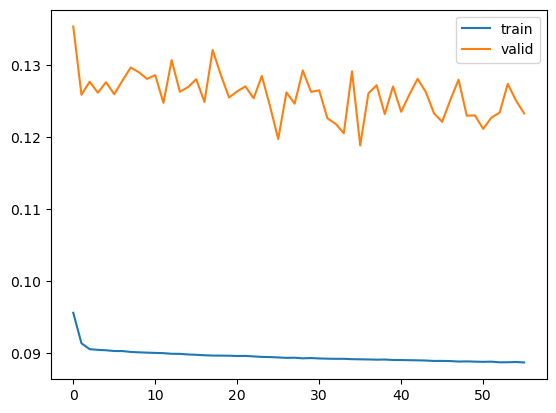

In [23]:
from matplotlib import pyplot
pyplot.plot(train_loss, label='train')
pyplot.plot(val_loss, label='valid')
pyplot.legend()
pyplot.show()

In [17]:
model = DNN_Regression(input_dim=train_x.shape[1]).to(device)
model.load_state_dict(torch.load(config['save_path']))
preds = predict(test_loader, model, device)
print(preds)

100%|████████████████████████████████████████████████████████████████████████████████| 122/122 [00:00<00:00, 1127.39it/s]

[[ 4.7410073 -5.2875695]
 [ 4.9366355 -5.535367 ]
 [ 5.0586224 -5.665696 ]
 ...
 [ 4.8813663 -5.2810183]
 [ 4.764916  -5.34764  ]
 [ 3.94889   -4.62692  ]]


In [18]:
prediction = []
for i in preds:
    if i[0] > i[1]:
        prediction.append(0)
    else:
        prediction.append(1)

In [19]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1)
pca_train_x = pca.fit_transform(train_x)

pca_test_x = pca.transform(test_x)

df = pd.DataFrame(pca_test_x)
df['y'] = prediction
df['groundTrue'] = test_y
df

,0,y,groundTrue
0,2.518758,0,0
1,2.633924,0,0
2,5.037992,0,0
3,7.563413,0,0
4,2.510550,0,0
...,...,...,...
31200,-7.454380,0,0
31201,-7.409502,1,1
31202,5.092651,0,0
31203,2.531582,0,0


/tmp/ipykernel_27735/920653628.py:5: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.scatterplot(


<AxesSubplot: xlabel='0', ylabel='y'>

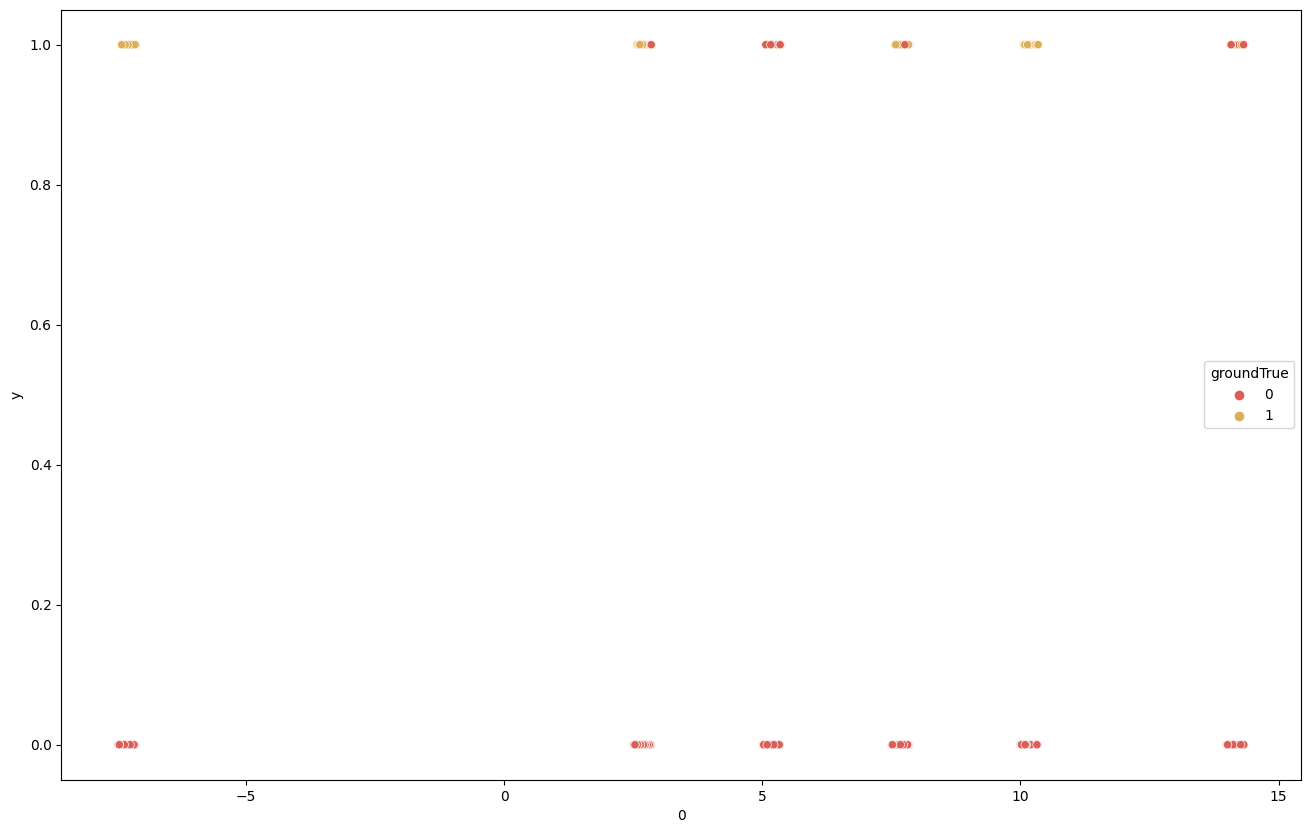

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(16,10))
sns.scatterplot(
    x=0, y='y',
    hue="groundTrue",
    palette=sns.color_palette("hls", 10),
    data=df,
    legend="full",
    alpha=1
)

In [21]:
print(classification_report(test_y, prediction))

              precision    recall  f1-score   support

           0       1.00      0.96      0.98     27490
           1       0.76      1.00      0.86      3715

    accuracy                           0.96     31205
   macro avg       0.88      0.98      0.92     31205
weighted avg       0.97      0.96      0.96     31205



In [25]:
from sklearn.metrics import det_curve
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay
from matplotlib import pyplot as plt
import matplotlib
import bob.measure

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def DETCurve(fps,fns):
    """
    Given false positive and false negative rates, produce a DET Curve.
    The false positive rate is assumed to be increasing while the false
    negative rate is assumed to be decreasing.
    """
    axis_min = min(fps[0],fns[-1])
    fig, ax = plt.subplots()
    plt.plot(fps,fns)
    plt.yscale('log')
    plt.xscale('log')
    ticks_to_use = [0.001,0.002,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,20,50]
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(ticks_to_use)
    ax.set_yticks(ticks_to_use)
    plt.axis([0.001,50,0.001,50])

def generate_det_curve(p_scores, n_scores):
        #matplotlib.use('TkAgg')

        plt.switch_backend('agg')
        bob.measure.plot.det(n_scores, p_scores, 1000, color = (0,0,0), linestyle = '-')
        bob.measure.plot.det_axis([0.01, 99, 0.01, 99])
        threshold = bob.measure.eer_threshold(n_scores, p_scores)
        far, frr = bob.measure.farfrr(n_scores, p_scores, threshold)
        
        print(far, frr)
        x = range(99)
        ax = plt.gca()
        #ax.plot(x)
        ax.set_aspect('equal', adjustable='box')
        plt.plot([100, -10], [100, -10], linestyle='--', label=f"Equal error rate = {max(far, frr)* 100}%")
        print("##########")
        print(max(far, frr) * 100)
        print("##########")
        plt.xlabel('FAR (%)')
        plt.ylabel('FRR (%)')
        plt.xticks(rotation=45)
        plt.grid(True)
        plt.legend(loc="lower right")
        
        plt.savefig('fig/det_SMOTE.png')
        plt.cla()
        plt.clf()
        
        return max(far, frr) * 100


In [23]:
prob_prediction = []
scores = []
for i in preds:
    scores.append(softmax(i)[1])
    prob_prediction.append(i[1])
    
scores = np.array(scores)
fpr, fnr, thresholds = det_curve(test_y, prob_prediction)
print(scores)

[4.4118959e-05 2.8317492e-05 2.2002807e-05 ... 3.8593640e-05 4.0565337e-05
 1.8857802e-04]


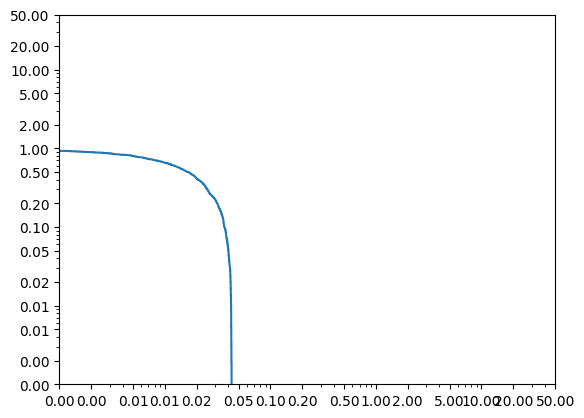

In [24]:
DETCurve(fpr, fnr)

In [26]:
labels = test_y

p_scores, n_scores = scores[np.where(labels == True)].astype(np.double), scores[np.where(labels == False)[0]].astype(np.double)

In [27]:
print(p_scores, n_scores)

generate_det_curve(p_scores, n_scores)

[0.95394832 0.80419391 0.96677178 ... 0.95829731 0.93076634 0.93410748] [4.41189586e-05 2.83174923e-05 2.20028069e-05 ... 3.85936401e-05
 4.05653373e-05 1.88578022e-04]
0.040341942524554385 0.040376850605652756
##########
4.037685060565275
##########


4.037685060565275

KeyboardInterrupt: 